In [1]:
!pip install torchinfo
!pip install torchmetrics
!pip install transformers
!pip install openprompt

  Obtaining dependency information for openprompt from https://files.pythonhosted.org/packages/e1/4b/6c7ff0738e403e437869117f74adb456797b1d6fb41acf7c04c3ab1aaceb/openprompt-1.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for sentencepiece==0.1.96 from https://files.pythonhosted.org/packages/7f/21/7a88f09026e1a69358b845d6b5deb36a2a54457ba7317f8f1047d9bbb643/sentencepiece-0.1.96-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for yacs from https://files.pythonhosted.org/packages/38/4f/fe9a4d472aa867878ce3bb7efb16654c5d63672b86dc0e6e953a67018433/yacs-0.1.8-py3-none-any.whl.metadata
  Obtaining dependency information for rouge==1.0.0 from https://files.pythonhosted.org/packages/43/cc/e18e33be20971ff73a056ebdb023476b5a545e744e3fc22acd8c758f1e0d/rouge-1.0.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.4/146.4 kB 2.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 M

In [2]:
import os
import time
import warnings
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torchinfo import summary
from torchmetrics.classification import Accuracy, AUROC
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

from openprompt import PromptForClassification, PromptDataLoader
from openprompt.plms import load_plm
from openprompt.prompts import ManualTemplate, ManualVerbalizer
from openprompt.trainer import ClassificationRunner
from openprompt.data_utils import InputExample

warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(


In [3]:
%cd "/kaggle/input/hateful-meme"

/kaggle/input/hateful-meme


In [4]:
train_path = "processed_train.jsonl"
dev_path = "processed_dev.jsonl"
train_ex_path = "mem_train.json"
dev_ex_path = "mem_test.json"
hurtlex_path = "hurtlex_EN.tsv"

In [5]:
train_df = pd.read_json(train_path, lines=True)
dev_df = pd.read_json(dev_path, lines=True)
ex_train_df = pd.read_json(train_ex_path)
ex_dev_df = pd.read_json(dev_ex_path)

train_df.head()

,id,img,label,text,caption
0,42953,img/42953.png,0,its their character not their color that matters,a man with a bald head and a bald face
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,a man and woman kissing in front of a lake
2,13894,img/13894.png,0,putting bows on your pet,a cat with a red bow on its neck
3,37408,img/37408.png,0,i love everything and everybody! except for sq...,"a dog with a capt that says, exitouris ha sures"
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...",a man in a suit and tie is standing in front o...


In [6]:
ex_train_df["text"] = train_df["text"]
ex_dev_df["text"] = dev_df["text"]
ex_train_df["caption"] = train_df["caption"]
ex_dev_df["caption"] = dev_df["caption"]

ex_dev_df.head()

,clean_sent,org_sent,bert_tokens,label,img,race,entity,ent_tokens,race_tokens,attack,text,caption
0,white people is this a shooting range,white people is this a shooting range,"[101, 2317, 2111, 2003, 2023, 1037, 5008, 2846...",1,08291.png,Black Male Black Male Black Male,Peanut allergy Family Parent Health Gender ide...,"[101, 21443, 2035, 24395, 2155, 6687, 2740, 59...","[101, 2304, 3287, 2304, 3287, 2304, 3287, 102]","[1, 0, 0, 0, 0]",white people is this a shooting range,two children sitting on the ground eating fruit
1,bravery at its finest,bravery at its finest,"[101, 16534, 2012, 2049, 10418, 102]",1,46971.png,White Male Black Male Black Male Black Male Bl...,Fried chicken Chicken glasses,"[101, 13017, 7975, 7975, 7877, 102]","[101, 2317, 3287, 2304, 3287, 2304, 3287, 2304...","[1, 0, 0, 0, 0]",bravery at its finest,a man with a beard and a shirt on
2,your order comes to 3750 and your white privil...,your order comes to $37.50 and your white priv...,"[101, 2115, 2344, 3310, 2000, 18034, 2692, 199...",1,03745.png,White Female White Female White Female,unk,"[101, 4895, 2243, 102]","[101, 2317, 2931, 2317, 2931, 2317, 2931, 102]","[1, 0, 0, 0, 0]",your order comes to $37.50 and your white priv...,a woman sitting at a desk with a laptop
3,it is time to send these parasites back to the...,it is time.. to send these parasites back to t...,"[101, 2009, 2003, 2051, 2000, 4604, 2122, 2399...",1,83745.png,unk,Crusades Middle Ages Knight First Crusade Knig...,"[101, 16282, 2015, 2690, 5535, 5000, 2034, 162...","[101, 4895, 2243, 102]","[1, 0, 0, 0, 0]",it is time.. to send these parasites back to t...,a person holding a bottle of beer
4,mississippi wind chime,mississippi wind chime,"[101, 5900, 3612, 9610, 4168, 102]",1,80243.png,unk,World War II 20 July plot Nazism Execution Ges...,"[101, 2088, 2162, 2462, 2322, 2251, 5436, 1315...","[101, 4895, 2243, 102]","[1, 0, 0, 0, 0]",mississippi wind chime,a black and white photo of a group of men walk...


In [7]:
hurt_df = pd.read_csv("hurtlex_EN.tsv", sep="\t")
hurt_df.head()

,id,pos,category,stereotype,lemma,level
0,EN1382,n,qas,no,gag reel,inclusive
1,EN7077,a,cds,no,snotty,conservative
2,EN6856,n,is,yes,mendicant,conservative
3,EN5485,n,re,no,maffias,conservative
4,EN5024,n,cds,no,lying in trade,conservative


In [8]:
def get_data(df, **configs):
    dataset = []
    for i, row in df.iterrows():
        meta_data = dict()

        for meta_name, column_name in configs.items():
            meta_data[meta_name] = row[column_name]

        dataset.append(InputExample(
            guid=str(i), text_a=row["text"],
            label=row["label"], meta=meta_data
        ))
    return dataset

In [9]:
import spacy

nlp = spacy.load("en_core_web_sm")

def remove_and_lemma(row):
    text = row["text"] + " " + row["caption"] + " " + row["entity"]
    text = text.lower()
    return [token.lemma_ for token in nlp(text) if not token.is_stop and token.is_alpha]

ex_train_df["tokens"] = ex_train_df.apply(remove_and_lemma, axis=1)
ex_dev_df["tokens"] = ex_dev_df.apply(remove_and_lemma, axis=1)
ex_dev_df.head()

,clean_sent,org_sent,bert_tokens,label,img,race,entity,ent_tokens,race_tokens,attack,text,caption,tokens
0,white people is this a shooting range,white people is this a shooting range,"[101, 2317, 2111, 2003, 2023, 1037, 5008, 2846...",1,08291.png,Black Male Black Male Black Male,Peanut allergy Family Parent Health Gender ide...,"[101, 21443, 2035, 24395, 2155, 6687, 2740, 59...","[101, 2304, 3287, 2304, 3287, 2304, 3287, 102]","[1, 0, 0, 0, 0]",white people is this a shooting range,two children sitting on the ground eating fruit,"[white, people, shooting, range, child, sit, g..."
1,bravery at its finest,bravery at its finest,"[101, 16534, 2012, 2049, 10418, 102]",1,46971.png,White Male Black Male Black Male Black Male Bl...,Fried chicken Chicken glasses,"[101, 13017, 7975, 7975, 7877, 102]","[101, 2317, 3287, 2304, 3287, 2304, 3287, 2304...","[1, 0, 0, 0, 0]",bravery at its finest,a man with a beard and a shirt on,"[bravery, fine, man, beard, shirt, fry, chicke..."
2,your order comes to 3750 and your white privil...,your order comes to $37.50 and your white priv...,"[101, 2115, 2344, 3310, 2000, 18034, 2692, 199...",1,03745.png,White Female White Female White Female,unk,"[101, 4895, 2243, 102]","[101, 2317, 2931, 2317, 2931, 2317, 2931, 102]","[1, 0, 0, 0, 0]",your order comes to $37.50 and your white priv...,a woman sitting at a desk with a laptop,"[order, come, white, privilege, discount, brin..."
3,it is time to send these parasites back to the...,it is time.. to send these parasites back to t...,"[101, 2009, 2003, 2051, 2000, 4604, 2122, 2399...",1,83745.png,unk,Crusades Middle Ages Knight First Crusade Knig...,"[101, 16282, 2015, 2690, 5535, 5000, 2034, 162...","[101, 4895, 2243, 102]","[1, 0, 0, 0, 0]",it is time.. to send these parasites back to t...,a person holding a bottle of beer,"[time, send, parasite, desert, person, hold, b..."
4,mississippi wind chime,mississippi wind chime,"[101, 5900, 3612, 9610, 4168, 102]",1,80243.png,unk,World War II 20 July plot Nazism Execution Ges...,"[101, 2088, 2162, 2462, 2322, 2251, 5436, 1315...","[101, 4895, 2243, 102]","[1, 0, 0, 0, 0]",mississippi wind chime,a black and white photo of a group of men walk...,"[mississippi, wind, chime, black, white, photo..."


In [10]:
mapping = {
    "ps": "negative stereotypes and ethnic slurs",
    "rci": "locations and demonyms",
    "pa": "professions and occupations",
    "ddf": "physical disabilities and diversity",
    "ddp": "cognitive disabilities and diversity",
    "dmc": "moral and behavioral defects",
    "is": "social and economic disadvantage",
    "or": "plants",
    "an": "animals",
    "asm": "male genitalia",
    "asf": "female genitalia",
    "pr": "prostitution",
    "om": "homosexuality",
    "qas": "potential negative connotations",
    "cds": "derogatory words",
    "re": "felonies and crime and immoral behavior",
    "svp": "seven deadly sins of the Christian tradition"
}
hurt_dict = dict(
    zip(hurt_df["lemma"], [mapping[cat] for cat in hurt_df["category"]])
)
hurt_dict["jew"]

'negative stereotypes and ethnic slurs'

In [11]:
def hurt_features(tokens):
    hurt_list = []
    tokens = set(tokens)
    for token in tokens:
        if token in hurt_dict:
            hurt_list.append(f"{token} is the offensive word about {hurt_dict[token]}")
    return " ".join(hurt_list) if len(hurt_list) != 0 else 'unk'

ex_train_df["hurt"] = ex_train_df["tokens"].apply(hurt_features)
ex_dev_df["hurt"] = ex_dev_df["tokens"].apply(hurt_features)
ex_dev_df.head()

,clean_sent,org_sent,bert_tokens,label,img,race,entity,ent_tokens,race_tokens,attack,text,caption,tokens,hurt
0,white people is this a shooting range,white people is this a shooting range,"[101, 2317, 2111, 2003, 2023, 1037, 5008, 2846...",1,08291.png,Black Male Black Male Black Male,Peanut allergy Family Parent Health Gender ide...,"[101, 21443, 2035, 24395, 2155, 6687, 2740, 59...","[101, 2304, 3287, 2304, 3287, 2304, 3287, 102]","[1, 0, 0, 0, 0]",white people is this a shooting range,two children sitting on the ground eating fruit,"[white, people, shooting, range, child, sit, g...",white is the offensive word about negative ste...
1,bravery at its finest,bravery at its finest,"[101, 16534, 2012, 2049, 10418, 102]",1,46971.png,White Male Black Male Black Male Black Male Bl...,Fried chicken Chicken glasses,"[101, 13017, 7975, 7975, 7877, 102]","[101, 2317, 3287, 2304, 3287, 2304, 3287, 2304...","[1, 0, 0, 0, 0]",bravery at its finest,a man with a beard and a shirt on,"[bravery, fine, man, beard, shirt, fry, chicke...",chicken is the offensive word about animals
2,your order comes to 3750 and your white privil...,your order comes to $37.50 and your white priv...,"[101, 2115, 2344, 3310, 2000, 18034, 2692, 199...",1,03745.png,White Female White Female White Female,unk,"[101, 4895, 2243, 102]","[101, 2317, 2931, 2317, 2931, 2317, 2931, 102]","[1, 0, 0, 0, 0]",your order comes to $37.50 and your white priv...,a woman sitting at a desk with a laptop,"[order, come, white, privilege, discount, brin...",white is the offensive word about negative ste...
3,it is time to send these parasites back to the...,it is time.. to send these parasites back to t...,"[101, 2009, 2003, 2051, 2000, 4604, 2122, 2399...",1,83745.png,unk,Crusades Middle Ages Knight First Crusade Knig...,"[101, 16282, 2015, 2690, 5535, 5000, 2034, 162...","[101, 4895, 2243, 102]","[1, 0, 0, 0, 0]",it is time.. to send these parasites back to t...,a person holding a bottle of beer,"[time, send, parasite, desert, person, hold, b...",parasite is the offensive word about animals
4,mississippi wind chime,mississippi wind chime,"[101, 5900, 3612, 9610, 4168, 102]",1,80243.png,unk,World War II 20 July plot Nazism Execution Ges...,"[101, 2088, 2162, 2462, 2322, 2251, 5436, 1315...","[101, 4895, 2243, 102]","[1, 0, 0, 0, 0]",mississippi wind chime,a black and white photo of a group of men walk...,"[mississippi, wind, chime, black, white, photo...",white is the offensive word about negative ste...


In [12]:
plm_type = "bert"
plm_name = "bert-base-uncased" #GroNLP/hateBERT"
# plm_type = "roberta"
# plm_name = "roberta-base"

classes = [0, 1]

#configs = {}
#configs = {"feat_1": "caption"}
#configs = {"feat_1": "caption", "feat_2": "race", "feat_3": "entity"}
#configs = {"feat_1": "caption", "feat_2": "entity"}
configs = {"feat_1": "caption", "feat_2": "race", "feat_3": "entity", "feat_4": "hurt"}
template = ['meme text: {"placeholder":"text_a"}'] + [f'{v}: {{"meta":"{k}"}}' for k, v in configs.items()] + ['It was {"mask"}']
template = ' [SEP] '.join(template)
print(template)

train_dataset = get_data(ex_train_df, **configs)
dev_dataset = get_data(ex_dev_df, **configs)

meme text: {"placeholder":"text_a"} [SEP] caption: {"meta":"feat_1"} [SEP] race: {"meta":"feat_2"} [SEP] entity: {"meta":"feat_3"} [SEP] hurt: {"meta":"feat_4"} [SEP] It was {"mask"}


In [13]:
use_cuda = True
batch_size = 12
n_epochs = 4
lr = 1e-5
loss_fn = torch.nn.CrossEntropyLoss()

In [14]:
plm, tokenizer, model_config, WrapperClass = load_plm(plm_type, plm_name)

# define the template
prompt_template = ManualTemplate(
    text = template,
    tokenizer = tokenizer,
)
# define the verbalizer
prompt_verbalizer = ManualVerbalizer(
    classes = classes,
    label_words = {
        0: ["normal"],
        1: ["hate"],
    },
    tokenizer = tokenizer,
)
# define the model
prompt_model = PromptForClassification(
    template = prompt_template,
    plm = plm,
    verbalizer = prompt_verbalizer,
)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [15]:
# data_loader
train_loader = PromptDataLoader(
    dataset = train_dataset,
    tokenizer = tokenizer,
    template = prompt_template,
    tokenizer_wrapper_class=WrapperClass,
    batch_size=batch_size,
    shuffle=True
)
dev_loader = PromptDataLoader(
    dataset = dev_dataset,
    tokenizer = tokenizer,
    template = prompt_template,
    tokenizer_wrapper_class=WrapperClass,
    batch_size=batch_size
)

tokenizing: 8500it [00:41, 203.25it/s]
tokenizing: 500it [00:02, 207.01it/s]


In [16]:
if use_cuda:
    prompt_model = prompt_model.cuda()

In [17]:
no_decay = ['bias', 'LayerNorm.weight']
# it's always good practice to set no decay to biase and LayerNorm parameters
optimizer_grouped_parameters = [
    {'params': [p for n, p in prompt_model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in prompt_model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=lr)
lr_schedular = CosineAnnealingLR(optimizer, 150)

for epoch in range(n_epochs):
    tot_loss = 0
    for step, inputs in enumerate(tqdm(train_loader, total=len(train_loader))):
        prompt_model.train()
        # zero gradients
        optimizer.zero_grad()

        if use_cuda:
            inputs = inputs.cuda()
        logits = prompt_model(inputs)
        labels = inputs['label']
        loss = loss_fn(logits, labels)
        loss.backward()
        tot_loss += loss.item()

        optimizer.step()
        
        if step % 300 == 1:
            total_probs = []
            total_targets = []

            prompt_model.eval()
            with torch.no_grad():
                for batch in dev_loader:
                    if use_cuda:
                        batch = batch.cuda()
                    logits = prompt_model(batch)
                    total_probs.extend(list(torch.softmax(logits, dim=-1).detach().cpu()[:, 1]))
                    total_targets.extend(list(batch['label'].detach().cpu()))
            metrics = {
                "acc": Accuracy(task="binary"),
                "auroc": AUROC(task="binary")
            }
            print(f"Epoch {epoch+1}, Acc: {metrics['acc'](torch.stack(total_probs), torch.stack(total_targets))}, Auroc: {metrics['auroc'](torch.stack(total_probs), torch.stack(total_targets))}")

                    
        lr_schedular.step()

  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 1, Acc: 0.515999972820282, Auroc: 0.5812197327613831
Epoch 1, Acc: 0.6019999980926514, Auroc: 0.6190651059150696
Epoch 1, Acc: 0.5479999780654907, Auroc: 0.6398521661758423


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 2, Acc: 0.5559999942779541, Auroc: 0.6544942259788513
Epoch 2, Acc: 0.5860000252723694, Auroc: 0.6777616143226624
Epoch 2, Acc: 0.5960000157356262, Auroc: 0.7115904688835144


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 3, Acc: 0.5979999899864197, Auroc: 0.7135747671127319
Epoch 3, Acc: 0.6359999775886536, Auroc: 0.7402665615081787
Epoch 3, Acc: 0.5960000157356262, Auroc: 0.7418348789215088


  0%|          | 0/709 [00:00<?, ?it/s]

Epoch 4, Acc: 0.6200000047683716, Auroc: 0.7596933841705322
Epoch 4, Acc: 0.6779999732971191, Auroc: 0.7570050954818726
Epoch 4, Acc: 0.6579999923706055, Auroc: 0.7685267329216003


In [18]:
total_probs = []
total_targets = []

prompt_model.eval()
with torch.no_grad():
    for batch in tqdm(dev_loader, total=len(dev_loader)):
        if use_cuda:
            batch = batch.cuda()
        logits = prompt_model(batch)
        total_probs.extend(list(torch.softmax(logits, dim=-1).detach().cpu()[:, 1]))
        total_targets.extend(list(batch['label'].detach().cpu()))

  0%|          | 0/42 [00:00<?, ?it/s]

In [19]:
metrics = {
    "acc": Accuracy(task="binary"),
    "auroc": AUROC(task="binary")
}
print("  Acc:", metrics['acc'](torch.stack(total_probs), torch.stack(total_targets)))
print("Auroc:", metrics['auroc'](torch.stack(total_probs), torch.stack(total_targets)))

  Acc: tensor(0.6280)
Auroc: tensor(0.7725)


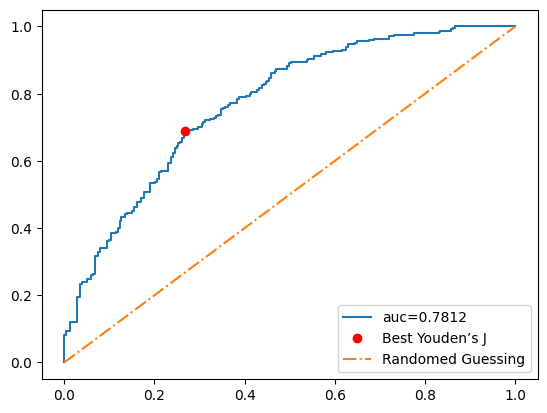

In [39]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(total_targets, total_probs)
x = np.arange(0, 1.05, 0.05)
idx = np.argmax(tpr-fpr)
auc = metrics.roc_auc_score(total_targets, total_probs)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.plot(fpr[idx], tpr[idx], 'ro', label="Best Youden’s J")
plt.plot(x, x, '-.', label="Randomed Guessing")
plt.legend(loc=4)
plt.show()

In [41]:
thresholds[np.argmax(tpr-fpr)]

0.13463089

In [47]:
import pickle

result = dict()
result["pos"] = np.where(total_probs>=thresholds[np.argmax(tpr-fpr)])
result["neg"] = np.where(total_probs<thresholds[np.argmax(tpr-fpr)])

with open("/kaggle/working/predict_result.pkl", "wb") as f:
    pickle.dump(result, f)

In [33]:
torch.cuda.empty_cache()

In [ ]:
with open("/kaggle/working/predict_result.pkl", "rb") as f:
    a = pickle.load(f)
a